In [9]:
# test the best multiprocessing pool number

# central no broken

# code for running on server
# with multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm

from multiprocessing import Pool

# Hyper parameters
EPISODES = 50 # times every setting is replicated
#IF_WRITEFILE = True
IF_WRITEFILE = False
RESULT_ADD = '/Users/valarian/SJTU/SJTU/毕业论文/Data/result/data_仿真结果/central/' + 'test_multiprocessing'

WARMUP_TIME = 2000
RUN_TIME = 5000

N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


# initialize parameters
R = {
        'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'car_move': 1.0,
        'gamma' : 1.0,
        'c_server' : 1,
        'phi' : 1.0,
        'f_server' : 1,
        'delta' : 1.0,
        'd_server' : 1,
        'broken' : 0,
        'period' : 90, #the maximal time for a carrier to move among areas
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]

# theoretical QN
# simulate situation with collect, fix and redistribute
# in this version, bikes found broken after a customer RIDING


# BikeNet is the class for simulate the CQN
# simulate by discrete event, in this program called a step
# the average customer served on time is out research object

class BikeNet():
    
    # initiate the parameters in this function
    def __init__(self, N, A, R, P, warmup_time, run_time):
        '''
        N: number of bikes in the CQN
        A: number of areas in the CQN
        R: rates of the system
        P: matrix of transit probability, including to broken
        warmup_time: the time to warm up the system
        run_time: the period of time during which get the performance
        '''
        
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0 # time cursor to indicate the system time in this episode, at the end of every episode should be default to zero
        self.served_customers = 0 # the performance indicator
        self.C = [] # time to be empty for collecting queue
        self.F = [] # time to be empty for fixing queue
        self.D = [] # time to be empty for distributing queue
        [heapq.heapify(_) for _ in [self.C, self.F, self.D]]
        # states: devide into 2 parts
        # A0, ... AA, C, F, D: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        # self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+3) # initiate the state list
        self.state1 = [int(self.N/self.A)]*self.A + [0]*3 # the last 3 numbers are for C, F, and D
        self.state2 = [[0]*self.A for i in range(self.A)]
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            # initially generate four events of arriving at each area
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        return self.state1, self.state2, self.T

    def simulate(self, writefile, i):
        if writefile:
            with open(RESULT_ADD+str(i)+'.csv', 'w') as fout:
                writer = csv.writer(fout)
                #writer.writerow(self.R)
                #writer.writerow(self.R.values())
                #writer.writerow(self.reset())
                self.reset()
                while self.T <= self.time_limit:
                    self.step()
                writer.writerow([self.R['lambda0'], self.N, self.served_customers / (self.T-self.warmup_time)])
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
            return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |2|3|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: return 2.0
        else: r = 1.0
        return random.expovariate(r)

        
    def add_event(self, kind):
        if kind == 2: 
            next_time = random.expovariate(self.R['gamma'])
            next_time += self.T if self.state1[-3] <= self.R['c_server'] else heapq.heappop(self.C)
            heapq.heappush(self.C, next_time)
            start, end = 'c', 'f'
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi'])
            next_time += self.T if self.state1[-2] <= self.R['f_server'] else heapq.heappop(self.F)
            heapq.heappush(self.F, next_time)
            start, end = 'f', 'd'
        elif kind == 4: 
            next_time = random.expovariate(self.R['delta'])
            next_time += self.T if self.state1[-1] <= self.R['d_server'] else heapq.heappop(self.D)
            heapq.heappush(self.D, next_time)
            start, end = 'd', random.choice(list(range(self.A)))
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: a bike finishes at collecting queue
         3: a bike finishes at fixed queue
         4: a bike finishes at distributed queue
        '''
        if kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[-3] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state1[-3] -= 1
            self.state1[-2] += 1
            heapq.heappop(self.scheduler)
            if self.state1[-3] < self.R['c_server']: heapq.heappop(self.C)
            self.add_event(3)
        elif kind == 3:
            self.state1[-2] -= 1
            self.state1[-1] += 1
            heapq.heappop(self.scheduler)
            if self.state1[-2] < self.R['f_server']: heapq.heappop(self.F)
            self.add_event(4)
        elif kind == 4:
            self.state1[-1] -= 1
            self.state1[terminal] += 1
            heapq.heappop(self.scheduler)
            if self.state1[-1] < self.R['d_server']: heapq.heappop(self.D)
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        return self.state1, self.state2, self.T

def run(i):
    #print('running %d'%(i))
    s = time.time()
    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  P=P,
                  warmup_time=WARMUP_TIME,
                  run_time=RUN_TIME)

    env.simulate(IF_WRITEFILE, i)
    e = time.time()
    print('finished running %d in %f'%(i, e-s))

import time
    
if __name__ == '__main__':
    result = []
    for t in range(3,5):
        start = time.time()
        WARMUP_TIME = 300
        RUN_TIME = 600
        p = Pool(t)
        for i in range(t):
            p.apply_async(run, args=(i,))
        p.close()
        p.join()
        end = time.time()
        result.append((end-start)/t)
        #print('total time %f'%(end-start))
    

finished running 0 in 0.676878
finished running 2 in 0.678537
finished running 1 in 0.726503
finished running 0 in 0.805908
finished running 1 in 0.820605
finished running 3 in 0.829517
finished running 2 in 0.835251


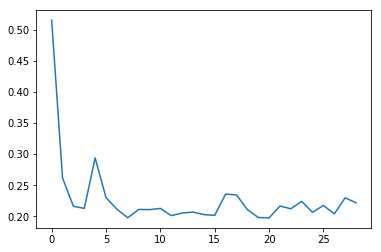

In [8]:
plt.plot(result)